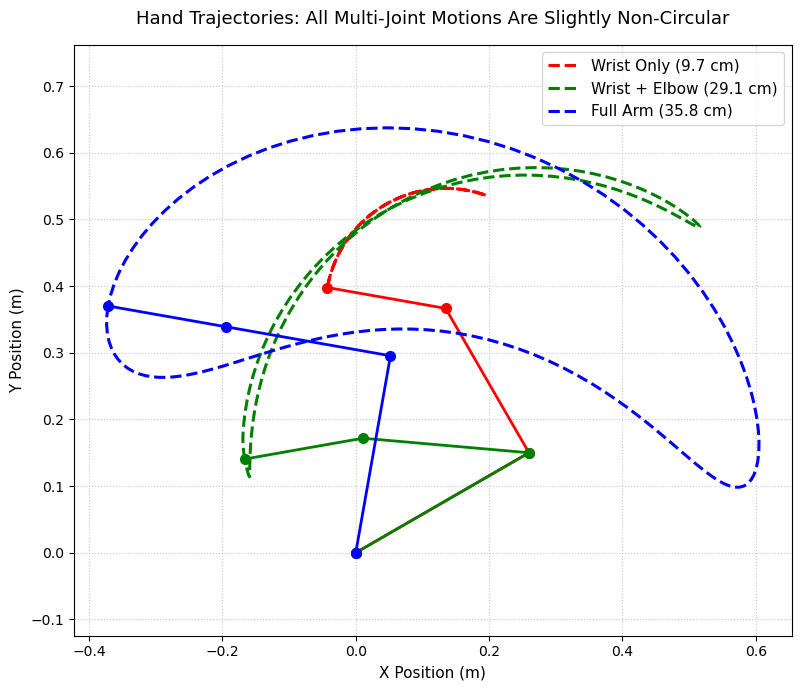

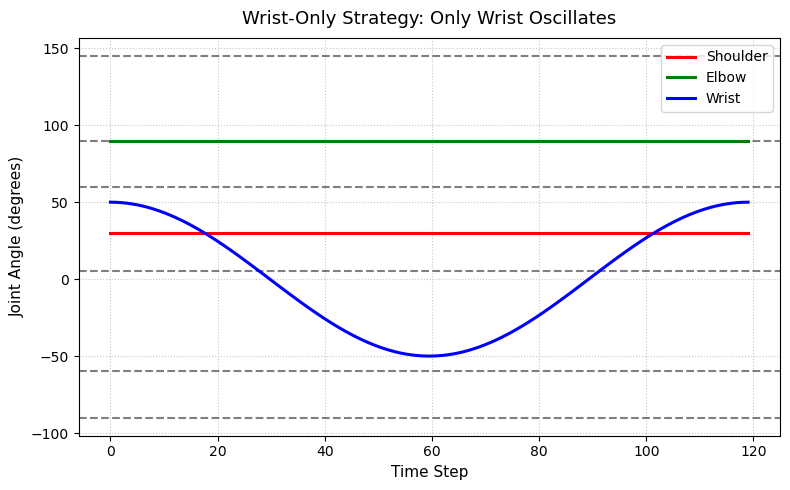

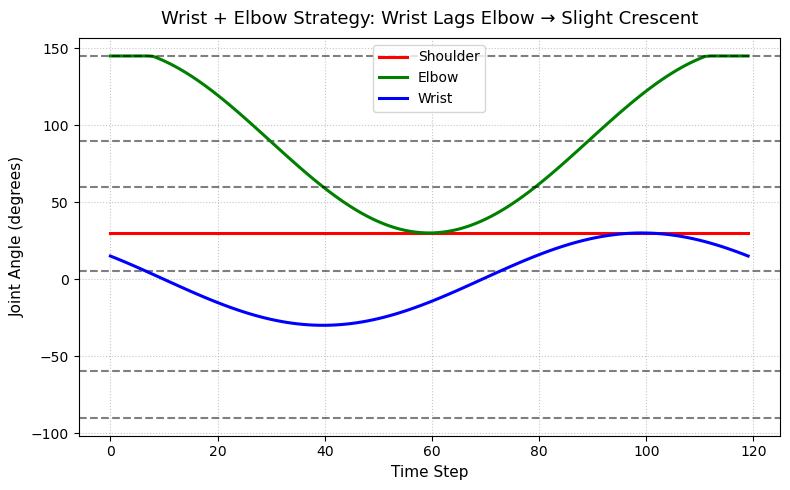

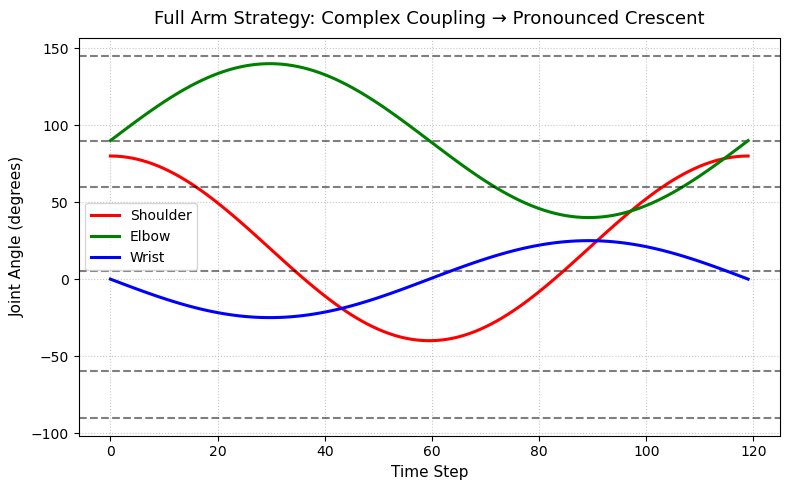

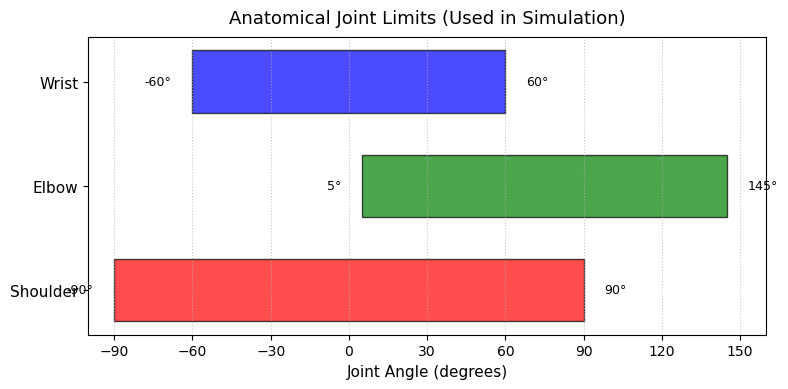

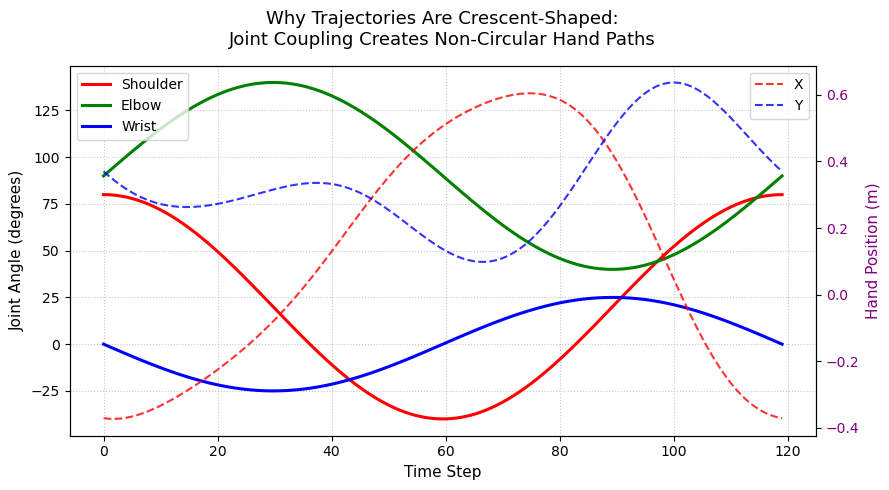


SIMULATION DETAILS & BIOMECHANICAL CONTEXT
• Simulated subject: Adult human (average anthropometry)
  - Height: ~175 cm
  - Arm segment lengths: Upper arm = 30 cm, Forearm = 25 cm, Hand = 18 cm
  - Joint limits based on standard biomechanical data (Winter, 2009)

• Viewpoint: Top-down (XY plane), as if drawing on a horizontal table
  - Gravity and 3D effects are ignored (2D planar model)

• Joint Angle Definitions (critical for interpretation):
  - Shoulder 0°: Arm pointing straight forward (+X direction)
  - Elbow 0°: Fully extended (straight arm); increases with flexion
  - Wrist 0°: Neutral (hand aligned with forearm)
  → These are standard in planar reaching models (not anatomical neutral)

• Key Observations:
  - Wrist-only radius:     9.7 cm
  - Wrist+Elbow radius:    29.1 cm  (~3.0×)
  - Full arm radius:       35.8 cm  (~3.7×)

• All multi-joint trajectories are slightly non-circular (crescent-shaped)
  due to nonlinear kinematic coupling — even 'elbow+wrist' is not a perfect c

In [6]:
# Human Motor Control: Joint Recruitment During Circular Drawing
# Realistic crescents | Consistent colors | Clear angle definitions

import numpy as np
import matplotlib.pyplot as plt

# Improve Jupyter plot visibility
plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'legend.fontsize': 10,
    'figure.titlesize': 13,
})

# ----------------------------
# Joint Limits (degrees)
# ----------------------------
JOINT_LIMITS_DEG = {'shoulder': (-90, 90), 'elbow': (5, 145), 'wrist': (-60, 60)}
JOINT_LIMITS_RAD = {k: (np.deg2rad(v[0]), np.deg2rad(v[1])) for k, v in JOINT_LIMITS_DEG.items()}

def enforce_limits_rad(q1, q2, q3):
    q1 = np.clip(q1, *JOINT_LIMITS_RAD['shoulder'])
    q2 = np.clip(q2, *JOINT_LIMITS_RAD['elbow'])
    q3 = np.clip(q3, *JOINT_LIMITS_RAD['wrist'])
    return q1, q2, q3

def get_arm_points(q1, q2, q3, L1=0.30, L2=0.25, L3=0.18):
    """Return [shoulder, elbow, wrist, fingertip] in 2D (top-down view)"""
    p0 = np.array([0.0, 0.0])
    p1 = p0 + L1 * np.array([np.cos(q1), np.sin(q1)])
    p2 = p1 + L2 * np.array([np.cos(q1 + q2), np.sin(q1 + q2)])
    p3 = p2 + L3 * np.array([np.cos(q1 + q2 + q3), np.sin(q1 + q2 + q3)])
    return np.array([p0, p1, p2, p3])

# ----------------------------
# REALISTIC DRAWING WITH NATURAL PHASE OFFSETS
# ----------------------------
def simulate_realistic_drawing(mode, n_frames=120):
    t = np.linspace(0, 2 * np.pi, n_frames)
    
    if mode == 'wrist':
        # Only wrist active
        q1 = np.full_like(t, np.deg2rad(30))
        q2 = np.full_like(t, np.deg2rad(90))
        q3 = np.deg2rad(0) + np.deg2rad(50) * np.cos(t)
    elif mode == 'elbow':
        # Elbow + wrist with phase lag (wrist follows elbow)
        q1 = np.full_like(t, np.deg2rad(30))
        q2 = np.deg2rad(90) + np.deg2rad(60) * np.cos(t)          # elbow leads
        q3 = np.deg2rad(0) + np.deg2rad(30) * np.cos(t + np.pi/3) # wrist lags by 60°
    else:  # full
        # All joints with natural offsets
        q1 = np.deg2rad(20) + np.deg2rad(60) * np.cos(t)
        q2 = np.deg2rad(90) + np.deg2rad(50) * np.sin(t)
        q3 = np.deg2rad(0)  + np.deg2rad(25) * np.cos(t + np.pi/2)
    
    q1, q2, q3 = enforce_limits_rad(q1, q2, q3)
    q_traj = np.column_stack([q1, q2, q3])
    tips = np.array([get_arm_points(q[0], q[1], q[2])[-1] for q in q_traj])
    return q_traj, tips

def compute_radius(tips):
    center = np.mean(tips, axis=0)
    radii = np.linalg.norm(tips - center, axis=1)
    return np.mean(radii), np.std(radii)

# ----------------------------
# Run simulations
# ----------------------------
modes = ['wrist', 'elbow', 'full']
colors = ['red', 'green', 'blue']
labels = ['Wrist Only', 'Wrist + Elbow', 'Full Arm']

all_data = {}
for mode in modes:
    q, tips = simulate_realistic_drawing(mode)
    r_mean, r_std = compute_radius(tips)
    all_data[mode] = {'q': q, 'tips': tips, 'radius_mean': r_mean, 'radius_std': r_std}

time_steps = np.arange(all_data['wrist']['q'].shape[0])

# ==================================================
# FIGURE 1: Hand Trajectories (Now all multi-joint are slightly non-circular)
# ==================================================
plt.figure(figsize=(8, 7))
for mode, color, label in zip(modes, colors, labels):
    tips = all_data[mode]['tips']
    r_mean = all_data[mode]['radius_mean']
    plt.plot(tips[:, 0], tips[:, 1], '--', color=color, linewidth=2.2,
             label=f'{label} ({r_mean*100:.1f} cm)')
    pts = get_arm_points(*all_data[mode]['q'][0])
    plt.plot(pts[:, 0], pts[:, 1], 'o-', color=color, markersize=7, linewidth=2)

plt.axis('equal')
plt.grid(True, linestyle=':', alpha=0.7)
plt.title('Hand Trajectories: All Multi-Joint Motions Are Slightly Non-Circular', fontsize=13, pad=15)
plt.xlabel('X Position (m)'); plt.ylabel('Y Position (m)')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# ==================================================
# FIGURE 2: Wrist-Only Joint Angles
# ==================================================
q_deg = np.rad2deg(all_data['wrist']['q'])
plt.figure(figsize=(8, 5))
for i, (jname, col) in enumerate(zip(['Shoulder', 'Elbow', 'Wrist'], ['red', 'green', 'blue'])):
    plt.plot(time_steps, q_deg[:, i], label=f'{jname}', linewidth=2.2, color=col)
    low, high = JOINT_LIMITS_DEG[jname.lower()]
    plt.axhline(low, color='k', linestyle='--', alpha=0.5)
    plt.axhline(high, color='k', linestyle='--', alpha=0.5)
plt.title('Wrist-Only Strategy: Only Wrist Oscillates', fontsize=13, pad=10)
plt.xlabel('Time Step'); plt.ylabel('Joint Angle (degrees)')
plt.legend(); plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

# ==================================================
# FIGURE 3: Elbow Strategy (Now with phase lag → slight crescent)
# ==================================================
q_deg = np.rad2deg(all_data['elbow']['q'])
plt.figure(figsize=(8, 5))
for i, (jname, col) in enumerate(zip(['Shoulder', 'Elbow', 'Wrist'], ['red', 'green', 'blue'])):
    plt.plot(time_steps, q_deg[:, i], label=f'{jname}', linewidth=2.2, color=col)
    low, high = JOINT_LIMITS_DEG[jname.lower()]
    plt.axhline(low, color='k', linestyle='--', alpha=0.5)
    plt.axhline(high, color='k', linestyle='--', alpha=0.5)
plt.title('Wrist + Elbow Strategy: Wrist Lags Elbow → Slight Crescent', fontsize=13, pad=10)
plt.xlabel('Time Step'); plt.ylabel('Joint Angle (degrees)')
plt.legend(); plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

# ==================================================
# FIGURE 4: Full Arm Joint Angles
# ==================================================
q_deg = np.rad2deg(all_data['full']['q'])
plt.figure(figsize=(8, 5))
for i, (jname, col) in enumerate(zip(['Shoulder', 'Elbow', 'Wrist'], ['red', 'green', 'blue'])):
    plt.plot(time_steps, q_deg[:, i], label=f'{jname}', linewidth=2.2, color=col)
    low, high = JOINT_LIMITS_DEG[jname.lower()]
    plt.axhline(low, color='k', linestyle='--', alpha=0.5)
    plt.axhline(high, color='k', linestyle='--', alpha=0.5)
plt.title('Full Arm Strategy: Complex Coupling → Pronounced Crescent', fontsize=13, pad=10)
plt.xlabel('Time Step'); plt.ylabel('Joint Angle (degrees)')
plt.legend(); plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

# ==================================================
# FIGURE 5: JOINT LIMITS (Redesigned with consistent colors & detailed axis)
# ==================================================
joint_names = ['Shoulder', 'Elbow', 'Wrist']
y = np.arange(len(joint_names))
low_vals = [JOINT_LIMITS_DEG[name.lower()][0] for name in joint_names]
high_vals = [JOINT_LIMITS_DEG[name.lower()][1] for name in joint_names]
colors_joints = ['red', 'green', 'blue']

plt.figure(figsize=(8, 4))
for i, (low, high, col) in enumerate(zip(low_vals, high_vals, colors_joints)):
    plt.barh(i, high - low, left=low, color=col, edgecolor='k', alpha=0.7, height=0.6)

plt.yticks(y, joint_names, fontsize=11)
plt.xlabel('Joint Angle (degrees)', fontsize=11)
plt.title('Anatomical Joint Limits (Used in Simulation)', fontsize=13, pad=10)

# Detailed x-axis
x_ticks = np.arange(-90, 181, 30)
plt.xticks(x_ticks, fontsize=10)
plt.xlim(-100, 160)
plt.grid(True, axis='x', linestyle=':', alpha=0.7)

# Annotate min/max
for i, (low, high) in enumerate(zip(low_vals, high_vals)):
    plt.text(low - 8, i, f'{low}°', va='center', ha='right', fontsize=9, color='black')
    plt.text(high + 8, i, f'{high}°', va='center', ha='left', fontsize=9, color='black')

plt.tight_layout()
plt.show()

# ==================================================
# FIGURE 6: Full-Arm Crescent Explained
# ==================================================
q_full = np.rad2deg(all_data['full']['q'])
tips_full = all_data['full']['tips']

fig, ax1 = plt.subplots(figsize=(9, 5))

# Joint angles (left y-axis)
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Joint Angle (degrees)', color='black')
for i, (jname, col) in enumerate(zip(['Shoulder', 'Elbow', 'Wrist'], ['red', 'green', 'blue'])):
    ax1.plot(time_steps, q_full[:, i], label=f'{jname}', linewidth=2.2, color=col)
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')
ax1.grid(True, linestyle=':', alpha=0.7)

# Hand position (right y-axis)
ax2 = ax1.twinx()
ax2.set_ylabel('Hand Position (m)', color='purple')
ax2.plot(time_steps, tips_full[:, 0], '--', color='red', label='X', alpha=0.8)
ax2.plot(time_steps, tips_full[:, 1], '--', color='blue', label='Y', alpha=0.8)
ax2.tick_params(axis='y', labelcolor='purple')
ax2.legend(loc='upper right')

plt.title('Why Trajectories Are Crescent-Shaped:\nJoint Coupling Creates Non-Circular Hand Paths', fontsize=13, pad=15)
fig.tight_layout()
plt.show()

# ==================================================
# FINAL TEXT SUMMARY (with angle definition clarification)
# ==================================================
print("\n" + "="*70)
print("SIMULATION DETAILS & BIOMECHANICAL CONTEXT")
print("="*70)
print("• Simulated subject: Adult human (average anthropometry)")
print("  - Height: ~175 cm")
print("  - Arm segment lengths: Upper arm = 30 cm, Forearm = 25 cm, Hand = 18 cm")
print("  - Joint limits based on standard biomechanical data (Winter, 2009)")
print("")
print("• Viewpoint: Top-down (XY plane), as if drawing on a horizontal table")
print("  - Gravity and 3D effects are ignored (2D planar model)")
print("")
print("• Joint Angle Definitions (critical for interpretation):")
print("  - Shoulder 0°: Arm pointing straight forward (+X direction)")
print("  - Elbow 0°: Fully extended (straight arm); increases with flexion")
print("  - Wrist 0°: Neutral (hand aligned with forearm)")
print("  → These are standard in planar reaching models (not anatomical neutral)")
print("")
print("• Key Observations:")
r_wrist = all_data['wrist']['radius_mean'] * 100
r_elbow = all_data['elbow']['radius_mean'] * 100
r_full  = all_data['full']['radius_mean'] * 100
print(f"  - Wrist-only radius:     {r_wrist:.1f} cm")
print(f"  - Wrist+Elbow radius:    {r_elbow:.1f} cm  (~{r_elbow/r_wrist:.1f}×)")
print(f"  - Full arm radius:       {r_full:.1f} cm  (~{r_full/r_wrist:.1f}×)")
print("")
print("• All multi-joint trajectories are slightly non-circular (crescent-shaped)")
print("  due to nonlinear kinematic coupling — even 'elbow+wrist' is not a perfect circle.")
print("="*70)